In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [3]:
df = pd.read_csv("heart.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


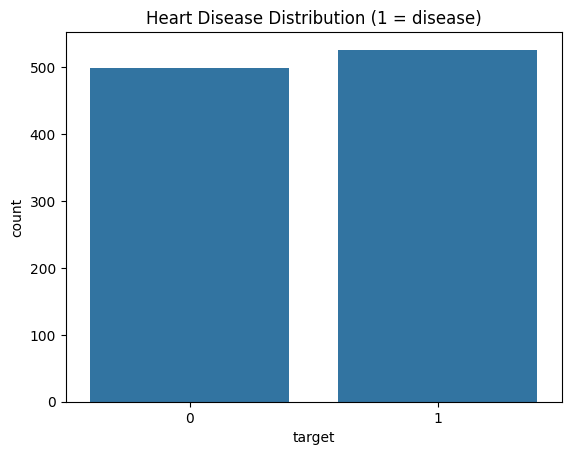

In [4]:
df.info()
df.describe()
df.isnull().sum()
sns.countplot(x='target', data=df)
plt.title("Heart Disease Distribution (1 = disease)")
plt.show()


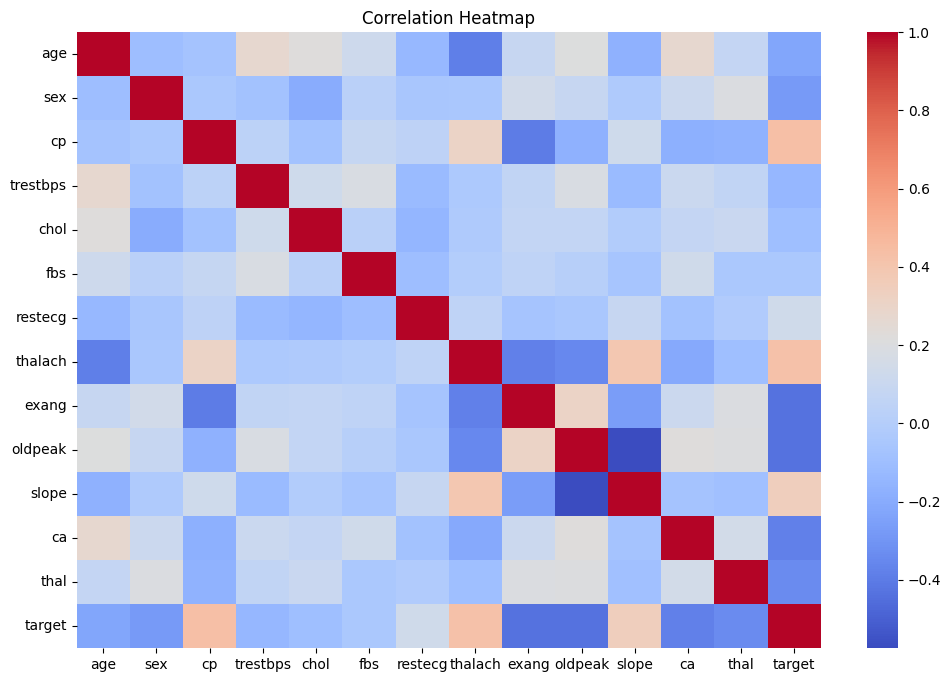

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [7]:
df = df.dropna()  


In [8]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
model_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
model_l1.fit(X_train, y_train)

train_acc_l1 = accuracy_score(y_train, model_l1.predict(X_train))
test_acc_l1 = accuracy_score(y_test, model_l1.predict(X_test))


In [11]:
model_l2 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000)
model_l2.fit(X_train, y_train)

train_acc_l2 = accuracy_score(y_train, model_l2.predict(X_train))
test_acc_l2 = accuracy_score(y_test, model_l2.predict(X_test))


In [12]:
model_el = LogisticRegression(penalty='elasticnet', solver='saga',
                              l1_ratio=0.5, max_iter=3000)
model_el.fit(X_train, y_train)

train_acc_el = accuracy_score(y_train, model_el.predict(X_train))
test_acc_el = accuracy_score(y_test, model_el.predict(X_test))


In [13]:
results = pd.DataFrame({
    "Penalty": ["L1", "L2", "ElasticNet"],
    "Train Accuracy": [train_acc_l1, train_acc_l2, train_acc_el],
    "Test Accuracy": [test_acc_l1, test_acc_l2, test_acc_el]
})

results


,Penalty,Train Accuracy,Test Accuracy
0,L1,0.871951,0.795122
1,L2,0.871951,0.795122
2,ElasticNet,0.871951,0.795122


### L1 Regularization Error

When applying:

`LogisticRegression(penalty='l1')`

 encountered the following error:

`ValueError: Solver lbfgs does not support l1 penalty`

**Reason:**  
The default solver (`lbfgs`) does not support L1 regularization.

**Fix:**  
Use a solver that supports L1, such as:

 `solver='liblinear'`
 `solver='saga'`

Example:

`LogisticRegression(penalty='l1', solver='saga')`


### Elastic Net Error

Using:

`LogisticRegression(penalty='elasticnet')`

Generated the error:

`ValueError: You must specify l1_ratio when using elasticnet`

**Reason:**  
Elastic Net combines L1 + L2, so it requires an explicit `l1_ratio`.

**Fix:**  
Specify both:

- `solver='saga'` (required)
- `l1_ratio=0.5` (or any value between 0 and 1)

Example:

`LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)`


### Convergence Warning

During training, I received warnings such as:

`ConvergenceWarning: lbfgs failed to converge`

**Reason:**  
The optimization did not converge within the default 100 iterations.

**Fix:**  
Increase the number of iterations:

`max_iter=2000` or higher.


### Additional Parameters Modified

1. **solver**
   - Changed for L1 and ElasticNet because only certain solvers support these penalties.
   - `saga` was used for both L1 and ElasticNet.
   - `lbfgs` used for L2.

2. **l1_ratio**
   - Required **only** for ElasticNet.
   - Controls the mixture of L1 and L2.

3. **max_iter**
   - Increased for all models to avoid convergence issues.

These changes ensure the logistic regression runs correctly for each penalty.


### Relationship Between Penalty, Solver, and l1_ratio

- **Penalty ↔ Solver**
  - L1 and ElasticNet cannot be optimized by `lbfgs`, so `saga` is required.
  
- **Penalty ↔ l1_ratio**
  - Only ElasticNet needs `l1_ratio`.
  - l1_ratio = 1 → Pure L1
  - l1_ratio = 0 → Pure L2

- **Penalty ↔ max_iter**
  - Regularization changes the optimization landscape.
  - More iterations are usually needed to reach convergence.
